In [52]:
import pandas as pd

# Читання даних з завантаженого файлу
user_behavior_df = pd.read_csv('./user_behavior_dataset.csv')

# Виведення розмірів датасету і назв колонок
user_behavior_shape = user_behavior_df.shape
user_behavior_columns = user_behavior_df.columns.tolist()

user_behavior_shape, user_behavior_columns

((700, 11),
 ['User ID',
  'Device Model',
  'Operating System',
  'App Usage Time (min/day)',
  'Screen On Time (hours/day)',
  'Battery Drain (mAh/day)',
  'Number of Apps Installed',
  'Data Usage (MB/day)',
  'Age',
  'Gender',
  'User Behavior Class'])

In [53]:
# Перевірка на пропуски в датасеті
missing_values = user_behavior_df.isnull().sum()

missing_values

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

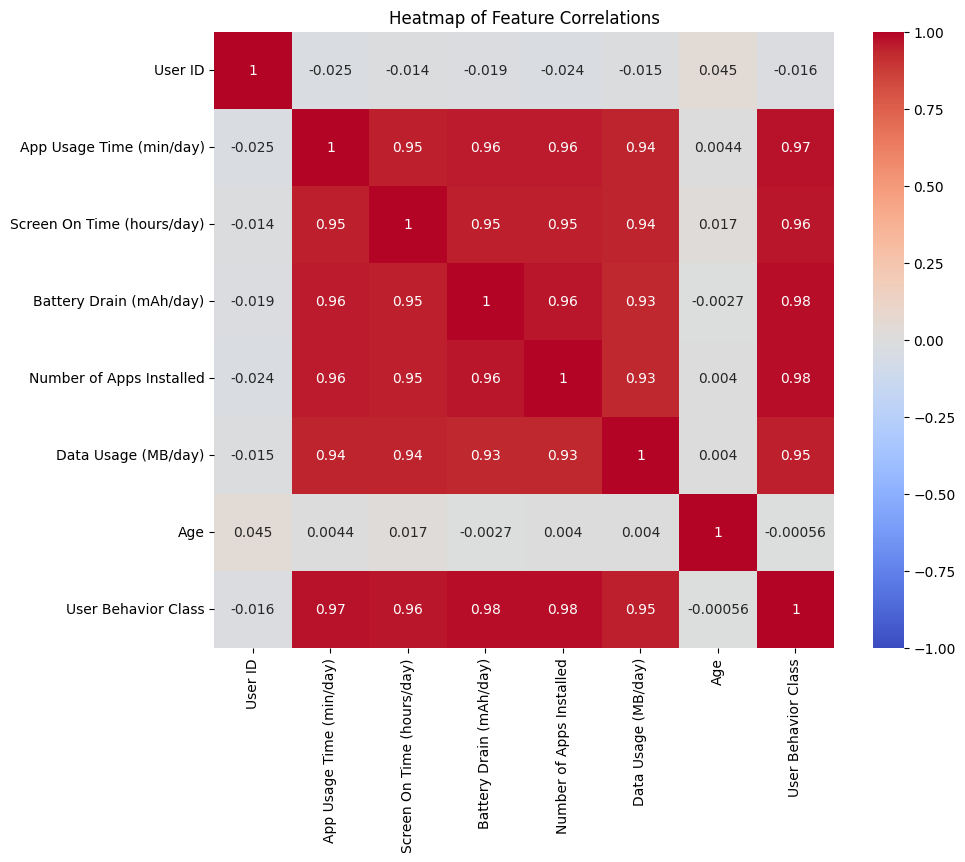

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Оскільки деякі колонки можуть бути категоріальними, залишимо тільки числові для кореляційного аналізу
numeric_df = user_behavior_df.select_dtypes(include=['float64', 'int64'])

# Кореляційна матриця для числових ознак
correlation_matrix = numeric_df.corr()

# Теплова карта кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Heatmap of Feature Correlations")
plt.show()

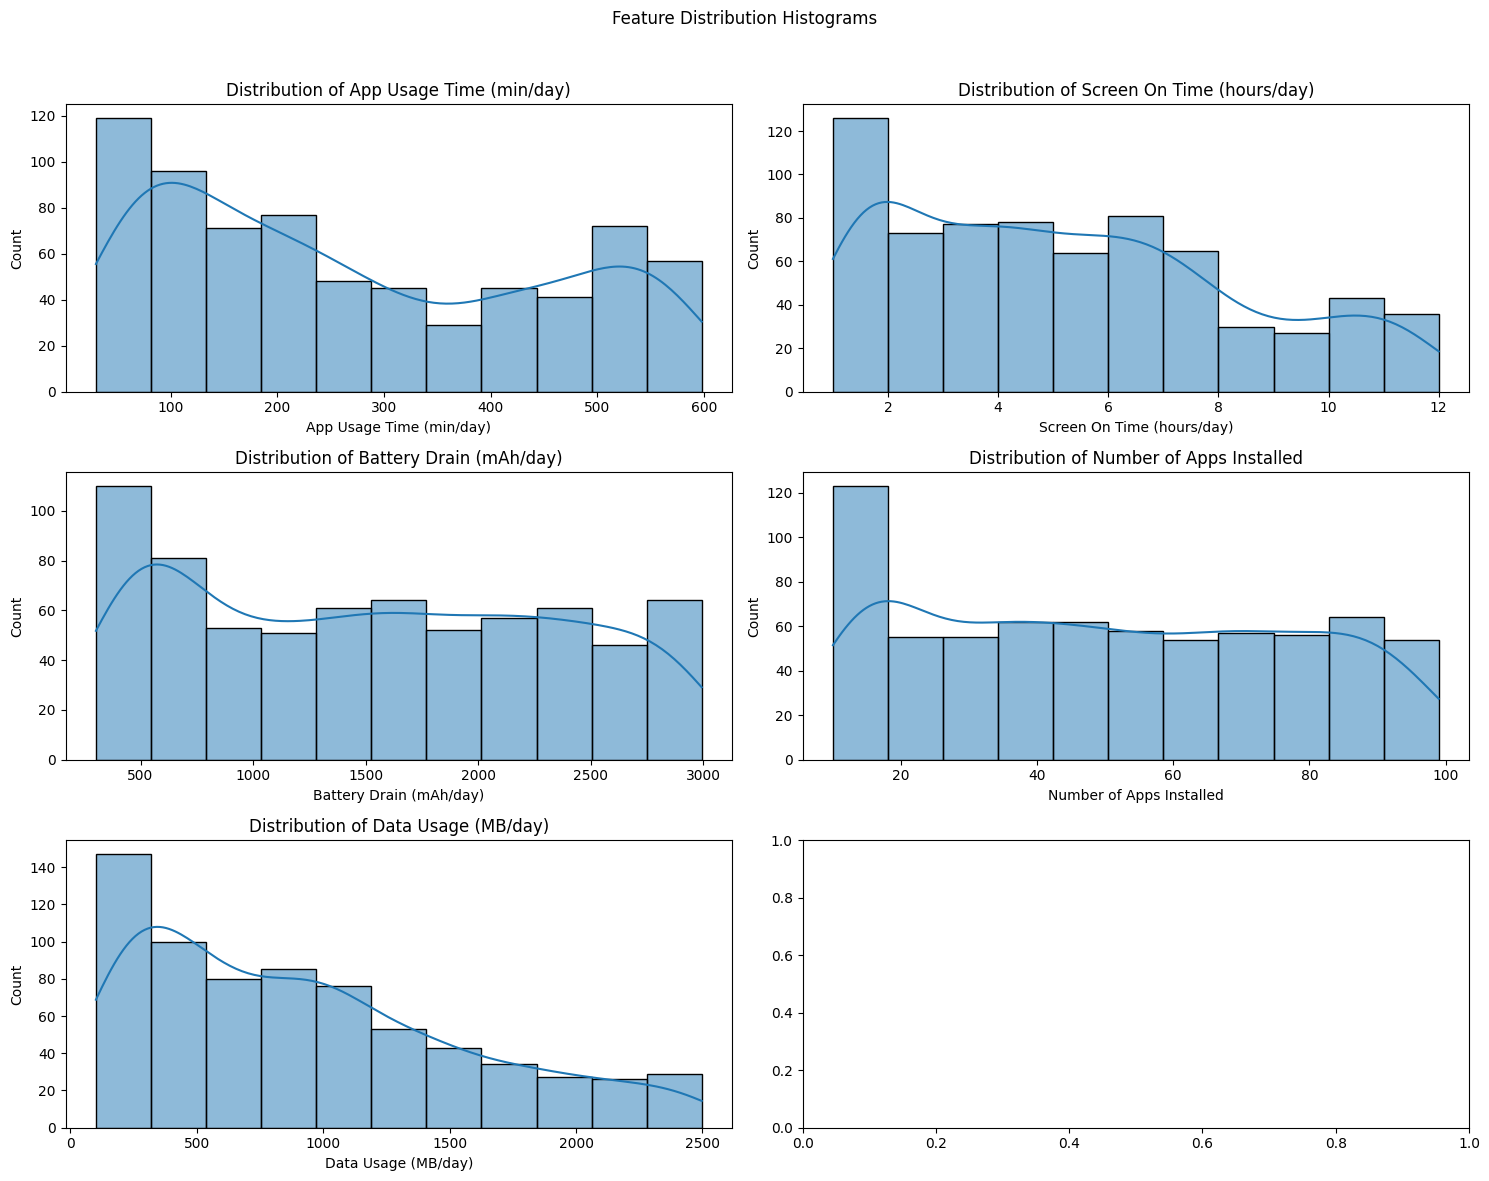

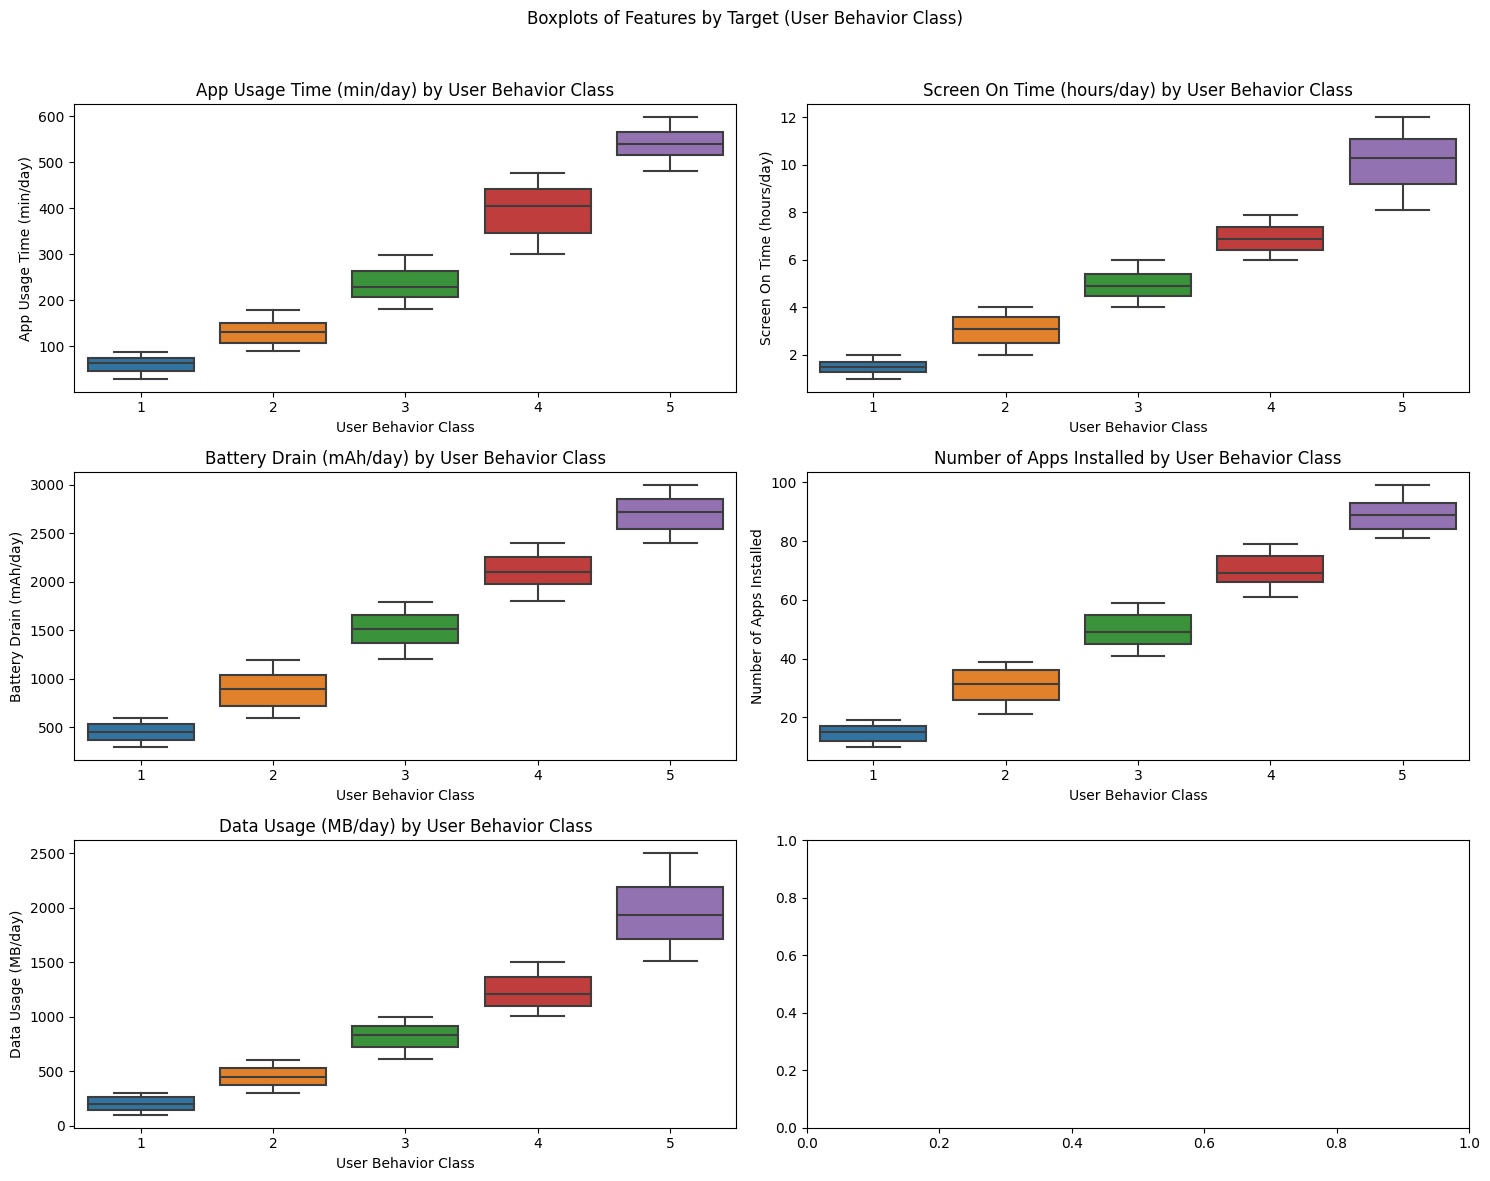

In [55]:
# Вибір декількох числових ознак для побудови гістограм і boxplots
selected_features = ["App Usage Time (min/day)", "Screen On Time (hours/day)", 
                     "Battery Drain (mAh/day)", "Number of Apps Installed", "Data Usage (MB/day)"]

# Гістограми розподілу обраних ознак
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Feature Distribution Histograms')

for i, feature in enumerate(selected_features):
    row, col = divmod(i, 2)
    sns.histplot(data=user_behavior_df, x=feature, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Boxplots для обраних ознак по відношенню до цільової змінної
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Boxplots of Features by Target (User Behavior Class)')

for i, feature in enumerate(selected_features):
    row, col = divmod(i, 2)
    sns.boxplot(data=user_behavior_df, x="User Behavior Class", y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by User Behavior Class')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [56]:
from sklearn.preprocessing import StandardScaler


# Вибираємо ознаки, які будемо нормалізувати
features_to_normalize = ["App Usage Time (min/day)", "Screen On Time (hours/day)", 
                         "Battery Drain (mAh/day)", "Number of Apps Installed", 
                         "Data Usage (MB/day)", "Age"]
scaler = StandardScaler()

# Нормалізація обраних ознак
user_behavior_df[features_to_normalize] = scaler.fit_transform(user_behavior_df[features_to_normalize])

# Перевірка результату нормалізації (перші кілька рядків)
user_behavior_df[features_to_normalize].head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age
0,0.688256,0.367626,0.423726,0.606096,0.300405,0.126383
1,-0.017668,-0.186771,-0.237198,-0.322441,0.022277,0.709506
2,-0.661471,-0.415053,-0.933550,-0.693856,-0.949607,0.292989
3,-0.181443,-0.154160,0.184279,0.197540,-0.091787,-1.539682
4,-0.475107,-0.317218,-0.193218,0.271823,0.091028,-0.623346


1. Повнозв'язані нейронні мережі (Fully Connected Feed-Forward Network)

In [57]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

user_behavior_df = pd.read_csv('./user_behavior_dataset.csv')

# Выбор признаков и целевой переменной
X = user_behavior_df.drop(columns=['User ID', 'User Behavior Class'])
y = user_behavior_df['User Behavior Class']

# Преобразование категориальных признаков в числовой формат
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Преобразование целевой переменной в числовой формат
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Преобразование целевой переменной в one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Создание нейронной сети
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/20
14/14 [==============================] - 1s 14ms/step - loss: 1.4793 - accuracy: 0.2589 - val_loss: 1.3409 - val_accuracy: 0.4286
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 1.2977 - accuracy: 0.4487 - val_loss: 1.1780 - val_accuracy: 0.5536
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 1.1336 - accuracy: 0.5848 - val_loss: 1.0194 - val_accuracy: 0.6161
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.9745 - accuracy: 0.6942 - val_loss: 0.8737 - val_accuracy: 0.8036
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.8300 - accuracy: 0.8304 - val_loss: 0.7477 - val_accuracy: 0.8571
Epoch 6/20
14/14 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.8661 - val_loss: 0.6497 - val_accuracy: 0.8750
Epoch 7/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.8750 - val_loss: 0.5642 - val_accuracy: 0.9286
Epoch 8/20
14/14 [=


Згорткові нейронні мережі (CNN)

In [58]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

In [59]:

# Завантаження та підготовка датасету
base_dir = 'Rice_Image_Dataset'  # Замініть на шлях до вашого датасету
output_dirs = {
    'train': 'Rice_Image_Dataset/train',
    'val': 'Rice_Image_Dataset/val',
    'test': 'Rice_Image_Dataset/test',
}

# Створення тренувальних, валідаційних і тестових підпапок
for subset, dir_path in output_dirs.items():
    os.makedirs(dir_path, exist_ok=True)


In [71]:
selected_classes = ['Arborio', 'Basmati']

for class_name in selected_classes:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)

    # Розділення даних
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Копіювання файлів у відповідні папки
    for subset, subset_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        subset_dir = os.path.join(output_dirs[subset], class_name)
        os.makedirs(subset_dir, exist_ok=True)

        for image in subset_images:
            src_path = os.path.join(class_dir, image)
            dst_path = os.path.join(subset_dir, image)
            shutil.copy(src_path, dst_path)



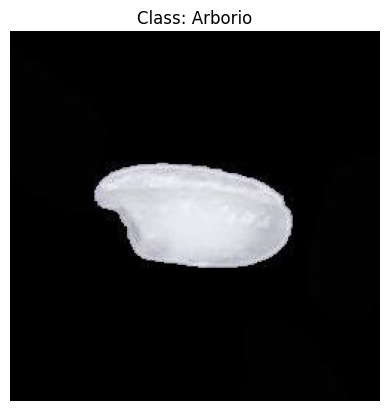

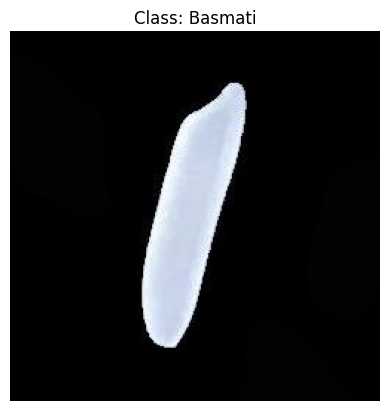

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Відображення по 1 фотографії кожного класу
for class_name in selected_classes:
    train_class_dir = os.path.join(output_dirs['train'], class_name)  # Шлях до тренувальних даних класу
    images = os.listdir(train_class_dir)  # Список файлів у папці
    if images:  # Перевірка, чи є файли
        example_image = images[0]  # Перше зображення
        example_path = os.path.join(train_class_dir, example_image)  # Повний шлях до зображення
        
        # Завантаження і відображення зображення
        img = mpimg.imread(example_path)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')  
        plt.show()


from scratch

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [62]:
# Шлях до тренувальної, валідаційної і тестової папок
train_dir = 'Rice_Image_Dataset/train'
val_dir = 'Rice_Image_Dataset/val'
test_dir = 'Rice_Image_Dataset/test'

In [63]:
# Генератори даних
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [64]:
# Завантаження даних
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 24000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


Transfer Learning 


In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [75]:
# Архітектура моделі
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 класи
])

In [76]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    steps_per_epoch=100, 
    validation_steps=20   
)

Epoch 1/10
100/100 [==============================] - 28s 283ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 2/10
100/100 [==============================] - 28s 276ms/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 0.0093 - val_accuracy: 0.9980
Epoch 3/10
100/100 [==============================] - 27s 273ms/step - loss: 9.0595e-04 - accuracy: 0.9997 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 4/10
100/100 [==============================] - 27s 268ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9993
Epoch 5/10
100/100 [==============================] - 27s 268ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 6/10
100/100 [==============================] - 27s 273ms/step - loss: 4.5102e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 7/10
100/100 [==============================] - 27s 268ms/step - loss: 9.1926e-04 - accuracy: 0.9994 - val_loss: 0.0

In [79]:
# Оцінка
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Точність на тестових даних (Transfer Learning): {test_accuracy:.2f}")

94/94 [==============================] - 6s 59ms/step - loss: 0.0015 - accuracy: 0.9997
Точність на тестових даних (Transfer Learning): 1.00


In [80]:
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

In [81]:
# Завантаження EfficientNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Заморожування

16705208/16705208 [==============================] - 1s 0us/step


In [82]:
# Додавання власних шарів
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 класи
])

In [83]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
history = model.fit(train_data, epochs=5, validation_data=val_data, steps_per_epoch=100, 
    validation_steps=20 )

Epoch 1/5
100/100 [==============================] - 39s 393ms/step - loss: 0.7056 - accuracy: 0.5075 - val_loss: 0.7616 - val_accuracy: 0.5063
Epoch 2/5
100/100 [==============================] - 38s 383ms/step - loss: 0.7031 - accuracy: 0.5241 - val_loss: 0.6866 - val_accuracy: 0.5234
Epoch 3/5
100/100 [==============================] - 38s 377ms/step - loss: 0.6892 - accuracy: 0.5453 - val_loss: 0.7123 - val_accuracy: 0.5188
Epoch 4/5
100/100 [==============================] - 37s 366ms/step - loss: 0.7070 - accuracy: 0.5275 - val_loss: 0.6922 - val_accuracy: 0.4688
Epoch 5/5
100/100 [==============================] - 37s 375ms/step - loss: 0.6923 - accuracy: 0.5216 - val_loss: 0.6874 - val_accuracy: 0.4875


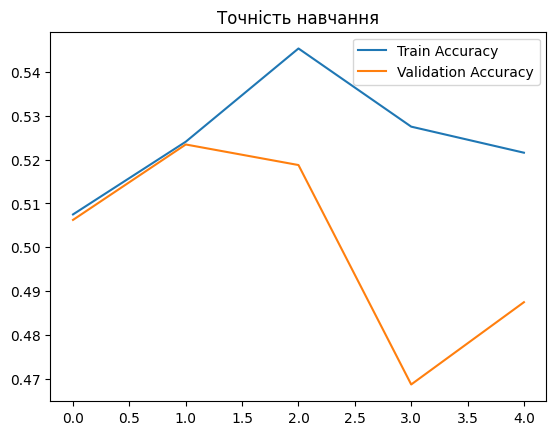

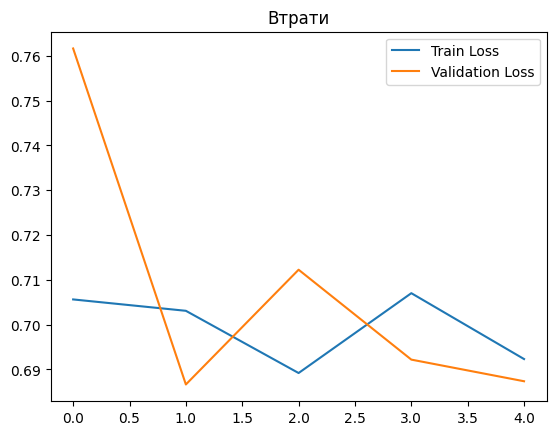

In [86]:
import matplotlib.pyplot as plt

# Точність
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Точність навчання')
plt.show()

# Втрати
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Втрати')
plt.show()

Рекурентні нейронні мережі (RNN)

In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string

data = pd.read_csv('../train_40k.csv')
data.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [111]:
# обрабка датасету
data = data.dropna(subset=['Text', 'Title'])  
data = data[data['Text'].str.strip() != '']  
min_samples_per_class = 50 
class_counts = data['Title'].value_counts()
valid_classes = class_counts[class_counts >= min_samples_per_class].index
data = data[data['Title'].isin(valid_classes)]
data = data[data['Text'].str.split().str.len() > 3]
import matplotlib.pyplot as plt



In [104]:
stop_words = set(stopwords.words('english'))
# Видалення стоп-слів та передобробка тексту
def preprocess_text(text):
    text = str(text).lower()
    text = ''.join([char for char in text if char not in string.punctuation]) 
    text = ' '.join([word for word in text.split() if word not in stop_words]) 
    return text


data['Text'] = data['Text'].apply(preprocess_text)

In [105]:
texts = data['Text'].values
labels = data['Title'].values

In [106]:
from sklearn.preprocessing import LabelEncoder

# Перетворення міток у числа
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [107]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)
y = to_categorical(labels)

From scratch

In [97]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [108]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(64),
    Dense(y.shape[1], activation='softmax')
])

In [109]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [110]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
46/46 [==============================] - 5s 61ms/step - loss: 2.8312 - accuracy: 0.1580 - val_loss: 2.7884 - val_accuracy: 0.1291
Epoch 2/10
46/46 [==============================] - 2s 52ms/step - loss: 2.2700 - accuracy: 0.3255 - val_loss: 2.3532 - val_accuracy: 0.3544
Epoch 3/10
46/46 [==============================] - 2s 52ms/step - loss: 1.7594 - accuracy: 0.4375 - val_loss: 2.2117 - val_accuracy: 0.3489
Epoch 4/10
46/46 [==============================] - 2s 54ms/step - loss: 1.4171 - accuracy: 0.5701 - val_loss: 1.9783 - val_accuracy: 0.4863
Epoch 5/10
46/46 [==============================] - 2s 54ms/step - loss: 1.0459 - accuracy: 0.6724 - val_loss: 1.7795 - val_accuracy: 0.4863
Epoch 6/10
46/46 [==============================] - 3s 56ms/step - loss: 0.7025 - accuracy: 0.8400 - val_loss: 1.7499 - val_accuracy: 0.5165
Epoch 7/10
46/46 [==============================] - 2s 54ms/step - loss: 0.4734 - accuracy: 0.9176 - val_loss: 1.8149 - val_accuracy: 0.5055
Epoch 8/10
46


Pretrained Word Embeddings

In [113]:
import numpy as np

In [114]:
#  GloVe embeddings
embedding_index = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [115]:


embedding_dim = 300  
word_index = tokenizer.word_index  

# Инициализация embedding matrix
embedding_matrix = np.zeros((10000, embedding_dim)) 
for word, i in word_index.items():
    if i < 10000:  # Проверка на вхождение в лимит
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [116]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=10000, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=100, 
              trainable=False),  # Замораживаем слой Embedding
    LSTM(64),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
46/46 [==============================] - 7s 86ms/step - loss: 2.6327 - accuracy: 0.2150 - val_loss: 2.3762 - val_accuracy: 0.3352
Epoch 2/10
46/46 [==============================] - 3s 73ms/step - loss: 1.6612 - accuracy: 0.5172 - val_loss: 1.6855 - val_accuracy: 0.5055
Epoch 3/10
46/46 [==============================] - 3s 72ms/step - loss: 1.1051 - accuracy: 0.6971 - val_loss: 1.5795 - val_accuracy: 0.5549
Epoch 4/10
46/46 [==============================] - 3s 72ms/step - loss: 0.7924 - accuracy: 0.7946 - val_loss: 1.3056 - val_accuracy: 0.6566
Epoch 5/10
46/46 [==============================] - 3s 72ms/step - loss: 0.6826 - accuracy: 0.8098 - val_loss: 1.3748 - val_accuracy: 0.6758
Epoch 6/10
46/46 [==============================] - 3s 72ms/step - loss: 0.5898 - accuracy: 0.8441 - val_loss: 1.2739 - val_accuracy: 0.6841
Epoch 7/10
46/46 [==============================] - 3s 72ms/step - loss: 0.4553 - accuracy: 0.8674 - val_loss: 1.3163 - val_accuracy: 0.6896
Epoch 8/10
46